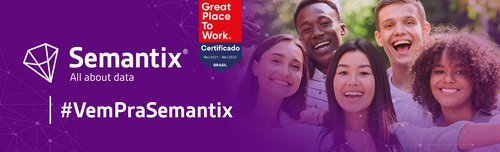

# Análise de microdados do Enem 2019

### Professor: Rodrigo Rebouças
### Projeto Final - Semantix
### Curso: Big Data Science
### Aluno: Alexander E. C. Alves

### Github: https://github.com/AlexanderAlves77/data-science-portfolio/microdados_enem_2019

**Objetivo:**

O objetivo deste projeto é utilizar as técnicas apresentadas no curso para analisar possíveis diferenças de rendimento entre escolas públicas e privadas presentes nos microdados do Enem. A intuição, baseada em todo o histórico da educação pública no Brasil, é que o rendimento dos egressos do ensino público seja, na média, inferior àquele observado entre alunos de escolas privadas. 

## Análise exploratória

Os dados utilizados neste experimento são disponibilizados pelo Inep em <p>
 https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem.  <p>
Para os modelos de classificação de alunos, foram utilizados os dados mais recentes, do Enem 2019. 

Para o primeiro grupo de modelos, usamos as seguintes propriedades do registro:


|Propriedade      | Descrição                             |
|:--------------- |:--------------------------------------|
| TP_ESCOLA	      | Tipo de escola do Ensino Médio <sup>1</sup>|
| NU_NOTA_CN      |Nota da prova de Ciências da Natureza  |
| NU_NOTA_CH	  |Nota da prova de Ciências Humanas      |
| NU_NOTA_LC	  |Nota da prova de Linguagens e Códigos  |
| NU_NOTA_MT	  |Nota da prova de Matemática            |
| NU_NOTA_REDACAO |Nota da prova de redação               |

Para o segundo grupo, foram utilizadas as seguintes propriedades:

|Propriedade     | Descrição                              |
|:---------------|:-------------------------------------- |
| TP_ESCOLA	     | Tipo de escola do Ensino Médio         |
| TP_ENSINO	     | Tipo de instituição que concluiu ou concluirá o Ensino Médio|
| SG_UF_ESC	     | Sigla da Unidade da Federação da escola|
| TP_SEXO	     | Sexo                                   |
| TP_COR_RACA	 | Cor/raça                               |
| Q001	         | Formação acadêmica do pai              |
| Q002           | Formação acadêmica da mãe              |
| Q005           | Número de pessoas na residência        |
| Q006           | Faixa de renda familiar mensal         |
| Q007           | Família contrata empregada doméstica   |
| NOTA_MEDIA     | Média das notas objetivas <sup>2</sup> |
| NU_NOTA_REDACAO| Nota da redação                        |

**Observações:**

1. Os valores possíveis para esse campo são: 1. Não informou; 2. Pública; 3. Privada; 4. Exterior. Utilizamos nesta análise apenas os registros que apresetnem valor 1 ou 2 nesta propriedade.
2. A *feature* NOTA_MEDIA é calculada da seguinte forma: NOTA_MEDIA = (NU_NOTA_CN + NU_NOTA_CH + NU_NOTA_LC + NU_NOTA_MT) / 4


In [2]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
# Carregamos as bibliotecas que serão utilizadas para manipulação e visualização dos dados
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
import matplotlib.gridspec as gridspec

from fastai.tabular import *
from google.colab import drive 
from xgboost import XGBClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn import metrics, linear_model
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Uma função para ajudar no pré-processamento
# A idéia é utilizar essa função para microdados de diferente anos

def notas_Enem(arquivo):
  # Colunas a serem lidas no arquivo
  features = [ 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO','TP_ESCOLA' ]

  # Lendo o arquivo, retirando os registros em que um dos valores não esteja presente.
  df = pd.read_csv(arquivo, encoding = 'latin1', usecols = features, sep = ';').dropna()

  df['NOTA_MEDIA'] = (df['NU_NOTA_CN'] + df['NU_NOTA_CH'] + df['NU_NOTA_LC'] + df['NU_NOTA_MT']) / 4

  # Filtrando os registros de com alunos de escolas públicas e privadas (valores 2 e 3 no campo TP_ESCOLA)
  df = df.loc[df['TP_ESCOLA'].isin([2, 3])]
  df.loc[df['TP_ESCOLA'] == 2, 'TP_ESCOLA'] = 'Pública'
  df.loc[df['TP_ESCOLA'] == 3, 'TP_ESCOLA'] = 'Privada'

  return df

In [5]:
drive.mount('/content/drive')

# Carregando o dataset a apartir da cópia do Drive
notas = notas_Enem('/content/drive/MyDrive/Semantix/Projeto_Final_Big_Data_Science/MICRODADOS_ENEM_2019.csv')
notas.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,NOTA_MEDIA
9,Pública,543.9,548.1,502.5,480.7,400.0,518.800
26,Privada,618.2,744.7,636.3,713.7,900.0,678.225
28,Pública,430.4,466.8,515.9,394.1,580.0,451.800
31,Pública,371.8,501.4,518.6,442.0,660.0,458.450
34,Pública,567.3,584.1,595.8,704.5,620.0,612.925


### Distribuição entre as classes

Ao analisarmos a distribuição de alunos entre os dois grupos, tanto no dataset original quanto nos subconjuntos de teste e treinamento, percebemos que o dataset é bastante desbalanceado. Cerca de 83% dos elementos da amostra pertencem à classe majoritária: alunos de escolas públicas. Esse desbalanceamento será levado em conta na análise dos modelos a seguir.

Para garantir a capacidade de comparação entre modelos, separamos o dataset em treinamento em teste, numa proporção de 80%/20%.

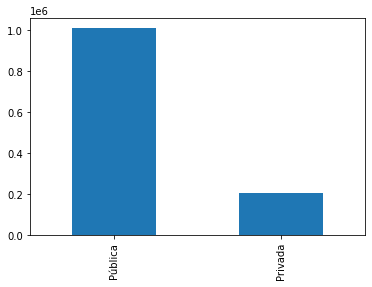

In [6]:
notas.TP_ESCOLA.value_counts().plot(kind='bar')
plt.show()

### Diferenças entre as classes

Ao analizarmos, por exemplo, a nota da redação, podemos concluir que existe uma diferença estatisticamente significante entre os dois grupos

In [7]:
notas[['TP_ESCOLA', 'NU_NOTA_REDACAO']].groupby('TP_ESCOLA').describe()

NU_NOTA_REDACAO                                                    \
                    count        mean         std  min    25%    50%    75%   
TP_ESCOLA                                                                     
Privada          207297.0  724.857089  156.853350  0.0  620.0  740.0  860.0   
Pública         1009824.0  554.557963  183.439247  0.0  480.0  580.0  660.0   

                   
              max  
TP_ESCOLA          
Privada    1000.0  
Pública    1000.0

In [8]:
pub = notas.loc[notas.TP_ESCOLA == 'Pública', 'NU_NOTA_REDACAO']
pri = notas.loc[notas.TP_ESCOLA == 'Privada', 'NU_NOTA_REDACAO']

pg.ttest(pri, pub)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,436.797621,334625.363663,two-sided,0.0,"[169.53, 171.06]",0.950382,inf,1.0


O teste nos mostra que a diferença entre as médias é estatisticamente significativa. O poder do teste é 1. Abaixo, vemos os histogramas das duas classes.

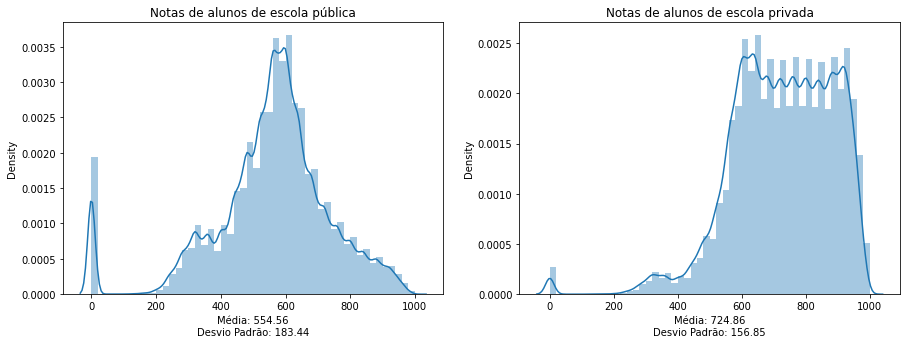

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

pub_plt = sns.distplot(pub, ax = axes[0], 
                       axlabel = f'Média: {pub.mean():.2f}\nDesvio Padrão: {pub.std():.2f}'
                       ).set_title('Notas de alunos de escola pública')
pri_plt = sns.distplot(pri,  
                       axlabel = f'Média: {pri.mean():.2f}\nDesvio Padrão: {pri.std():.2f}'
                       ).set_title('Notas de alunos de escola privada')

plt.show()

O mesmo se aplica à nota média nas provas objetivas:

In [10]:
notas[['TP_ESCOLA', 'NOTA_MEDIA']].groupby('TP_ESCOLA').describe()

NOTA_MEDIA                                                   \
               count        mean        std     min      25%      50%   
TP_ESCOLA                                                               
Privada     207297.0  573.860283  70.403569  179.35  524.925  579.625   
Pública    1009824.0  491.871809  62.241261    0.00  444.625  483.250   

                             
               75%      max  
TP_ESCOLA                    
Privada    625.025  818.525  
Pública    532.525  812.825

In [11]:
pub = notas.loc[notas.TP_ESCOLA=='Pública', 'NOTA_MEDIA']
pri = notas.loc[notas.TP_ESCOLA=='Privada', 'NOTA_MEDIA']
pg.ttest(x = pri, y = pub, correction = False).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,533.74,1217119,two-sided,0.0,"[81.69, 82.29]",1.29,inf,1.0


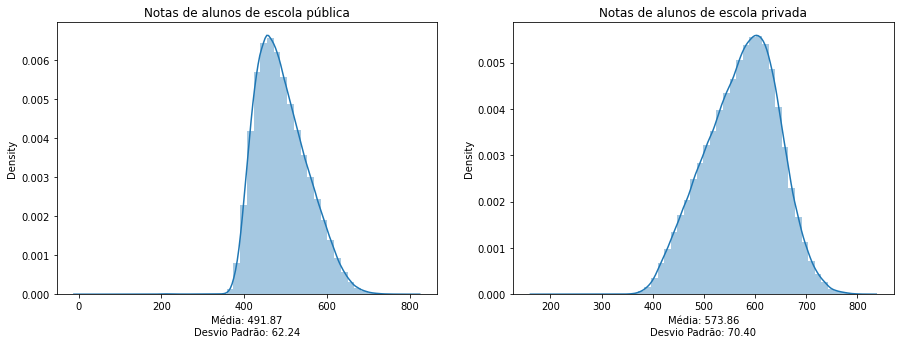

In [12]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

pub_plt = sns.distplot(pub, ax = axes[0], 
                       axlabel = f'Média: {pub.mean():.2f}\nDesvio Padrão: {pub.std():.2f}'
                       ).set_title('Notas de alunos de escola pública')
pri_plt = sns.distplot(pri,  
                       axlabel = f'Média: {pri.mean():.2f}\nDesvio Padrão: {pri.std():.2f}'
                       ).set_title('Notas de alunos de escola privada')

plt.show()

### Pré processamento

Agora, realizamos a normalização dos dados, a fim de acelerarmos o treinamento e teste dos modelos preditivos

In [13]:
std_features = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']
std = StandardScaler()
notas[std_features] = std.fit_transform(notas[std_features])

E, para fins de comparação dos modelos, separamos o dataset em treinamento em teste, numa proporção de 80%/20%

In [14]:
X_train, X_test, y_train, y_test = train_test_split(notas.drop(['TP_ESCOLA', 'NOTA_MEDIA'], axis = 1),
                                                    notas.TP_ESCOLA, test_size = 0.2, random_state = 1)

## Classificando alunos a partir de suas notas

Para o primeiro grupo de classificadores, utilizaremos as notas dos alunos, bem como sua classe de renda no questionário sócio-econômico, para classificar se o aluno é egresso de escola pública ou privada. 

O primeiro classificador utilizado é o KNN, que agrupa ocorrências da amostra a partir de um critério de similaridade. O hiper-parâmetro mais importante desse modelo é justamente o número de núcleos a partir dos quais o modelo realizará o agrupamento. Nesse caso, utilizamos dois núcleos, seguindo a intuição de que há dois grupos distintos no *dataset*: alunos egressos de escolas públicas e privadas.

Acurácia: 0.7383300811338195
F1-score médio: 0.7607632764463567
F1-score da classe minoritária: 0.41574713592544693


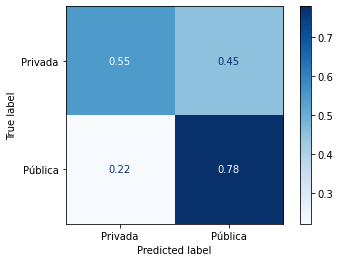

In [15]:
# Instanciamos o modelo KNN com dois núcleos
knn = KNeighborsClassifier(n_neighbors=2)

# Definimos uma função para treinamento e exbição dos resultados de um modelo
def treino_teste(model):
  # Ajustamos o modelo 
  model.fit(X_train, y_train)
  # Submetemos os dados de teste ao classificador
  y_pred = model.predict(X_test)

  # E observamos algumas métricas de desempenho desse modelo: acurácia, F1-score e matriz de confusão
  print(f'Acurácia: {metrics.accuracy_score(y_test, y_pred)}')
  print(f'F1-score médio: {metrics.f1_score(y_test, y_pred, average="weighted")}')
  print(f'F1-score da classe minoritária: {metrics.f1_score(y_test, y_pred, pos_label="Privada")}')
  metrics.plot_confusion_matrix(model, X_test, y_test, cmap = plt.cm.Blues, normalize = 'true')

treino_teste(knn)

O resultado acima, com acurácia de cerca de 83%, que é a proporção de elementos da classe majoritária (escola pública), com score F1 da classe minoritária (privada) abaixo de 30%, indicam que, muito provavelmente, o classificador KNN é simples demais para modelar o problema proposto. O poder de classificação modelado ainda não apresenta evidencia forte o suficiente da diferença de rendimento entre alunos de escolas públicas e privadas. A matriz de confusão acima, por sua vez, indica que o modelo erra bastante dado ao viés da classe majoritária. Prosseguimos, então, nosso experimento com mais 3 classificadores.

O próximo modelo utilizado é o de descida de gradiente estocástica (SGD), selecionamos a função de custo (loss) do tipo 'modified_huber', que resulta num modelo de regressão linear que é mais robusto contra outliers. A função de custo (loss) do tipo "elasticnet" favorece a seleção de variáveis (feature selection) durante o próprio treinamento. Tendo em vista o desbalanceamento entre as classes, utilizaremos o parâmetro class_weight="balanced", que pondera a função de erro por um fator inversamente proporcional à participação da classe na amostra.

Acurácia: 0.7366498921639109
F1-score médio: 0.7662851506100928
F1-score da classe minoritária: 0.4944321766561514


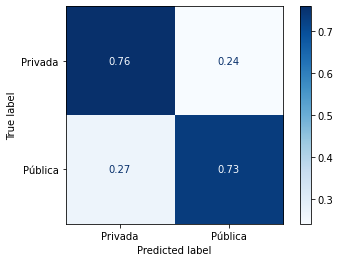

In [16]:
# Instanciamos um modelo SGD (descida do gradiente estocástica)
sgd = SGDClassifier(class_weight='balanced', loss='modified_huber', penalty='elasticnet', random_state=1)

# Executando o de treino e teste
treino_teste(sgd)

Embora apresente um score f1 melhor para a classe minoritária, e tenha acurácia melhor para essa classe (a matriz de confusão nos mostra 75% de acerto na classe minoritária), a acurácia ponderada para todo a amostra é baixa, tendo em vista o percentual de 26% erros na classe majoritária.

O próximo modelo utilizado será o de regressão logística.

Acurácia: 0.7531313546266817
F1-score médio: 0.7793117810473366
F1-score da classe minoritária: 0.5041749174917491


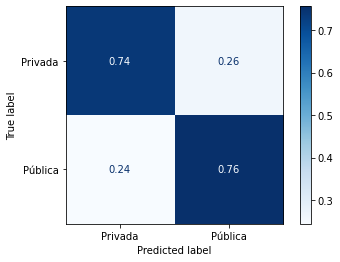

In [17]:
# Instanciamos o modelo de regressão logística
rlog = LogisticRegression(class_weight='balanced')

# Executando o de treino e teste
treino_teste(rlog)

O desempenho do modelo de regressão logística é ligeiramente superior ao do modelo anterior. A matriz de confusão acima, no entanto não apresenta uma redução significativa no viés de classificação. Cerca de 26% das ocorrências da classe minoritária foram classificadas incorretamente.

A seguir, testaremos um modelo de árvore de decisão.

Acurácia: 0.7550908904179933
F1-score médio: 0.780805092823181
F1-score da classe minoritária: 0.5048627548689839


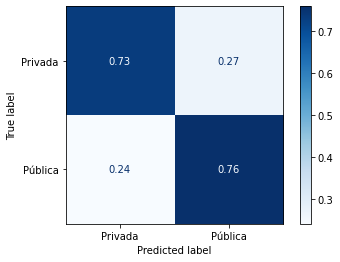

In [18]:
# Instanciamos uma árvore de decisão, com altura máxima de 3 nós
tree = DecisionTreeClassifier(class_weight='balanced', max_depth=7, random_state=1)

# Executando o de treino e teste
treino_teste(tree)

O modelo de árvore de decisão teve desempenho muito similar ao do modelo de regressão logística, em ambas as classes. Mais uma vez, é importante notar que a acurácia de quase 75% se deve ao fato de que o modelo erra na classificação de cerca um quarto dos registros da classe majoritária.

O próximo modelo utilizado é o RandomForest, que cria, internamente, uma série de árvores de decisão e apresenta, como resultado de classificação, uma combinação das respostas apresentadas pelas diversas árvores treinadas com os dados.

Acurácia: 0.8481832186505084
F1-score médio: 0.8251028102192284
F1-score da classe minoritária: 0.3948583592598657


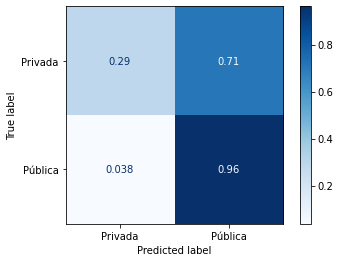

In [19]:
# Instanciamos o classificador Random Forest
random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=300, random_state=1)

# Executando o de treino e teste
treino_teste(random_forest)

O resultado desse classificador é, na verdade, uma composição de resultados dos 300 estimadores criados internamente. É interessante notar que, embora haja uma diferença significativa na acurácia, a melhora se dá apenas na classe majoritária: agora, com apenas 3% de erros. O modelo erra, no entanto, em cerca de 72% das ocorrências da classe minoritária.

A seguir, testamos um modelo de máquinas de vetores-suporte. Trata-se de um modelo que busca maximizar as fronteiras de separação entre classes. Neste experimento, utilizamos a versão linear do classificador, pois o custo de computação da versão não linear (SVC) é quadrático em relação ao número de registros na amostra, o que o torna inviável para um dataset com mais de 1 milhão de registros.

Acurácia: 0.7550580260860634
F1-score médio: 0.780779643866431
F1-score da classe minoritária: 0.504845661326889


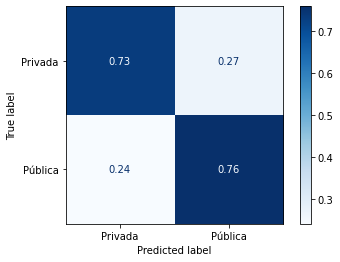

In [20]:
# Instanciamos o classificador SVM
lsvm = LinearSVC(class_weight='balanced', max_iter=3000, random_state=1, tol=5e-4)

# Executando o de treino e teste
treino_teste(lsvm)

Esse classificador tem desempenho ligeriamente superior ao dos modelos de regressão logística e árvore de decisão. Sua acurácia, assim como nos classificadores anteriores, é afetada pela porcentagem de erros na classe majoritária.

O próximo classificador utilizado é o XGBoost (eXtreme Gradient Boosting), que utiliza diversos modelos de árvore de decisão como estimadores subjacentes, mas faz uma otimização da busca por hiperparâmetros ótimos, de acordo com a tarefa selecionada. Nesse experimento, utilizamos o parâmetro objective='multi:softmax' para que modelo otimize os parâmetros para classificação.

Acurácia: 0.8512478176029578
F1-score médio: 0.8298640105814025
F1-score da classe minoritária: 0.4151376146788991


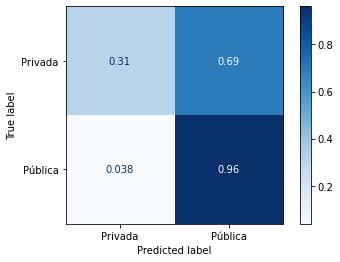

In [21]:
xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', num_class = 2, eval_metric = 'logloss',
                    eta = .1, max_depth = 14, colsample_bytree = .4, n_jobs = -1)
treino_teste(xgb)

Esse modelo tem acurácia maior, mas, assim como o modelo de Random Forest, esse ganho se dá como resultado de um viés de classificação para a classe majoritária. Quando observamos a matriz de confusão, percebemos que o modelo erra em quase 70% dos registros da classe minoritária.

Por fim, usaremos um classificador que utiliza os modelos já treinados anteriormente como estimadores subjacentes para gerar uma classificação própria. Neste caso, atribuímos pesos iguais para todos modelos e o resultado da classificação será dado pela maioria simples de votos. É possível testar diferentes combinações de pesos e alcançar um desempenho superior.

In [22]:
notas_X = notas[['NOTA_MEDIA', 'NU_NOTA_REDACAO']]
label_encoder = preprocessing.LabelEncoder()
notas_y = label_encoder.fit_transform(notas.TP_ESCOLA)

###  Simplificando o problema

A seguir, testamos alguns dos modelos utilizados anteriormente num problemas mais simples: reduzimos as dimensões do dataset, utilizando apenas a nota média das provas objetivas e a nota da redação. Isso nos permite visualizar a dispersão dos registros num plano.

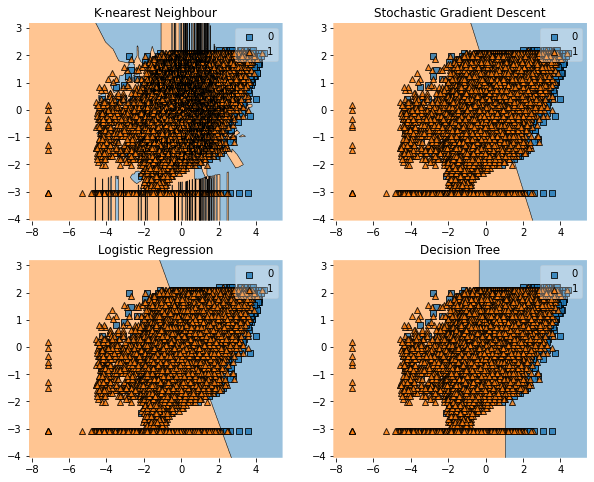

In [23]:
grid_spec = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize = (10, 8))

labels = ['K-nearest Neighbour', 'Stochastic Gradient Descent', 'Logistic Regression', 'Decision Tree']

for clf, lab, grd in zip([knn, sgd, rlog, tree], labels, itertools.product([0, 1], repeat = 2)):
  clf.fit(notas_X, notas_y)
  ax = plt.subplot(grid_spec[grd[0], grd[1]])
  fig = plot_decision_regions(X=notas_X.to_numpy(), y=notas_y, clf=clf)
  plt.title(lab)

## Prevendo a nota dos alunos a partir de seus dados socioeconômicos

In [34]:
# Criando um pipeline de pré-processamento. 
# A ideia é utilizar essa função para microdados de diferentes anos 
def socio_economico_enem(arquivo):
  # Colunas a serem lidas no arquivo
  features = [ 'TP_ESCOLA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO',  'NO_MUNICIPIO_ESC', 
        'TP_ENSINO', 'SG_UF_ESC', 'TP_COR_RACA', 'TP_SEXO', 'Q001', 'Q002', 'Q005', 'Q006', 'Q007',
        'TP_FAIXA_ETARIA' ]

  # Carregamos o dataset a partir do arquivo
  df = pd.read_csv(arquivo, nrows = 5000, encoding = 'latin1', usecols = features, sep = ';')

  # Filtramos os registros de com alunos de escolas públicas e privadas (valores 2 e 3 no campo TP_ESCOLA)
  df = df.loc[df['TP_ESCOLA'].isin([2, 3])]
  df.loc[df['TP_ESCOLA'] == 2, 'TP_ESCOLA'] = 'Pública'
  df.loc[df['TP_ESCOLA'] == 3, 'TP_ESCOLA'] = 'Privada'

  # Vamos atribuir o tipo de ensino com base na idade do aluno  
  df = df.loc[df['NO_MUNICIPIO_ESC'].notna()]
  df.loc[df['TP_ENSINO'].isna() & df['TP_FAIXA_ETARIA'] > 21, 'TP_ENSINO'] = 3
  df.loc[df['TP_ENSINO'].isna(), 'TP_ENSINO'] = 1

  # Filtramos os demais valores ausentes
  df.dropna(inplace = True)

  # Realizamos uma normalização dos valores das notas
  std_features = ['NOTA_MEDIA', 'NU_NOTA_REDACAO'] 
  df['NOTA_MEDIA'] = (df['NU_NOTA_CN'] + df['NU_NOTA_CH'] + df['NU_NOTA_LC'] + df['NU_NOTA_MT']) / 4

  std = StandardScaler()
  df[std_features] = std.fit_transform(df[std_features])

  # Usamos um encoder ordinal para transformar os valores presentes na coluna 'Q006' 
  # (faixa de renda) em valores numéricos, crescentes.
  ord_enc_features = ['Q001', 'Q002', 'Q001']
  ord_enc = OrdinalEncoder()
  df[ord_enc_features] = ord_enc.fit_transform(df[ord_enc_features])

  # Retira as colunas usadas para cálculos intermediários
  return df.drop(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT'], axis = 1)

In [35]:
see = socio_economico_enem('/content/drive/MyDrive/Semantix/Projeto_Final_Big_Data_Science/MICRODADOS_ENEM_2019.csv')
see.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_COR_RACA,TP_ESCOLA,TP_ENSINO,NO_MUNICIPIO_ESC,SG_UF_ESC,NU_NOTA_REDACAO,Q001,Q002,Q005,Q006,Q007,NOTA_MEDIA
26,2,F,1,Privada,1.0,Apucarana,PR,1.732665,4.0,4.0,2,E,A,2.411332
28,3,F,1,Pública,1.0,Alvorada,RS,-0.228566,4.0,1.0,3,A,A,-0.901240
31,2,F,2,Pública,1.0,Mogi das Cruzes,SP,0.261742,4.0,5.0,3,B,A,-0.803951
34,2,M,2,Pública,1.0,Lauro de Freitas,BA,0.016588,4.0,2.0,2,B,A,1.456001
53,3,M,3,Pública,1.0,Santa Rita,PB,-0.841450,3.0,4.0,4,C,A,-1.544224


Utilizamos um encoder ordinal, para as variáveis em que há uma gradação de valores categóricos

In [38]:
ord_enc_features = ['Q005', 'Q006', 'Q007']
enc = OrdinalEncoder()
see[ord_enc_features] = enc.fit_transform(see[ord_enc_features])
see.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_COR_RACA,TP_ESCOLA,TP_ENSINO,NO_MUNICIPIO_ESC,SG_UF_ESC,NU_NOTA_REDACAO,Q001,Q002,Q005,Q006,Q007,NOTA_MEDIA
26,2,F,1,Privada,1.0,Apucarana,PR,1.732665,4.0,4.0,1.0,4.0,0.0,2.411332
28,3,F,1,Pública,1.0,Alvorada,RS,-0.228566,4.0,1.0,2.0,0.0,0.0,-0.901240
31,2,F,2,Pública,1.0,Mogi das Cruzes,SP,0.261742,4.0,5.0,2.0,1.0,0.0,-0.803951
34,2,M,2,Pública,1.0,Lauro de Freitas,BA,0.016588,4.0,2.0,1.0,1.0,0.0,1.456001
53,3,M,3,Pública,1.0,Santa Rita,PB,-0.841450,3.0,4.0,3.0,2.0,0.0,-1.544224


Criamos variáveis dummies para as demais colunas categórcas

In [39]:
onehot_enc_features = ['TP_ESCOLA', 'TP_COR_RACA', 'TP_SEXO', 'TP_ENSINO', 'SG_UF_ESC']
see = pd.get_dummies(see, prefix=onehot_enc_features, columns=onehot_enc_features, drop_first=True)
see.head()

,TP_FAIXA_ETARIA,NO_MUNICIPIO_ESC,NU_NOTA_REDACAO,Q001,Q002,Q005,Q006,Q007,NOTA_MEDIA,TP_ESCOLA_Pública,...,SG_UF_ESC_PR,SG_UF_ESC_RJ,SG_UF_ESC_RN,SG_UF_ESC_RO,SG_UF_ESC_RR,SG_UF_ESC_RS,SG_UF_ESC_SC,SG_UF_ESC_SE,SG_UF_ESC_SP,SG_UF_ESC_TO
26,2,Apucarana,1.732665,4.0,4.0,1.0,4.0,0.0,2.411332,0,...,1,0,0,0,0,0,0,0,0,0
28,3,Alvorada,-0.228566,4.0,1.0,2.0,0.0,0.0,-0.901240,1,...,0,0,0,0,0,1,0,0,0,0
31,2,Mogi das Cruzes,0.261742,4.0,5.0,2.0,1.0,0.0,-0.803951,1,...,0,0,0,0,0,0,0,0,1,0
34,2,Lauro de Freitas,0.016588,4.0,2.0,1.0,1.0,0.0,1.456001,1,...,0,0,0,0,0,0,0,0,0,0
53,3,Santa Rita,-0.841450,3.0,4.0,3.0,2.0,0.0,-1.544224,1,...,0,0,0,0,0,0,0,0,0,0


## Previsão de Participantes em Anos Futuros

Por padrão, foram reservados 75% dados para treino e 25% para teste. A quantidade de dados disponíveis para este estudo não é tão grande, visto que só temos dados do Enem a partir do ano de 1998. O modelo preditivo criado faz uso de regressão linear para obter uma linha de tendência referente ao número de inscritos por ano. Onde o número de participantes por ano é a variável dependente e o ano de realização do exame é a variável independente. A Figura 22 mostra a linha obtida com os dados de treino utilizados no trecho de código acima.

In [36]:
# Criar meu conjunto de dados dos anos x participantes
dados = {'Ano' : [1998, 1999,2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
        'Participantes' : [157221, 346953, 390180, 1624131, 1829170, 1882393, 1552316, 3004491, 3742827, 3584569, 4018050,
                          4148720, 4626094, 5380856, 5791065, 7173563, 8722248, 7746472, 8627367, 6731341, 5513747, 5095270] }

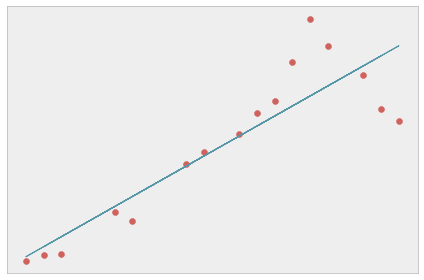

In [46]:
# Criando o DataFrame
dfml = pd.DataFrame(dados)

# separa ção de dados para estudo
x = dfml.Ano[:, np.newaxis ]
x_temp = x
y = dfml.Participantes

# dividindo a base entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(x_temp , y)

# criando modelo de regress ão linear
modelo = linear_model.LinearRegression()

# treinando o modelo criado com os dados de treinamento
modelo.fit(x_train, y_train )

# resultados do treino
plt.scatter(x_train, y_train, color = '#cf625d')
plt.plot(x_train, modelo.predict(x_train ), color ='#5597a6', linewidth =1)

# Apenas para evitar polui ção visual no grá fico
plt.xticks(())
plt.yticks(())
plt.tight_layout()
plt.style.use("bmh")
plt.show()